In [1]:
#import of library
#必要なライブラリのインポート
import os
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import load_img,img_to_array
import keras.preprocessing.image as Image
from keras.models import Model
from keras.datasets import fashion_mnist
from PIL import Image
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import keras
import glob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import math
from mpl_toolkits.mplot3d import Axes3D
import sys
import cv2

Using TensorFlow backend.


In [96]:
#list of variable
#変数リスト
#Division number
#分割数
cv = 10
#research gamma
#調べたいガンマ
#gamma_list = np.logspace(-3, -1, 5)
#gamma_list = [0.00001,0.0001,0.001,0.01,0.1]
#gamma_list = [0.04,0.02,0.01,0.005,0.0025]
#gamma_list = [0.012,0.011,0.01,0.009,0.008]
#gamma_list = [0.01075,0.0105,0.01,0.00975,0.0095]
gamma_list = [0.0102,0.0101,0.01,0.0099,0.0098]

#gamma_list = [0.00004,0.00002,0.00001,0.000005,0.0000025]

#gamma_list = [0.0000026,0.0000025,0.0000024]

#nu = 0.001のときgamma = 0.00035
#research nu
#gamma_list = [0.0013,0.00131,0.00132,0.00129,0.00128]
#調べたいnu
#nu_list = np.logspace(-3,-0.5,5)
#nu = 0.000185
nu = 0.1

#Number of test data
#実験データの数
data_range = 6000

#その他必要な変数
Tshirt_train = []
shirt_train = []

test = []

train_label = []
test_label = []

divide = data_range//cv

tmp_train = []
tmp_test = []

current_total_f_value = 0

#fashion_mnistを読み込み
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images,test_labels) = fashion_mnist.load_data()

In [53]:
#fashion_mnistをリサイズして返す関数
test_list = []
img_array_list = []
#width = height = 48
#fashion_mnistをリサイズして返す関数#
def resize_array_images(train_images,width,height,img_array_list):
    for i in range(len(train_images)):
        pil_img = Image.fromarray(train_images[i])
        #pil_img = pil_img.convert("RGB")
        pil_img = pil_img .resize((width,height), Image.BICUBIC)
        
        img_array = numpy.asarray(pil_img)
        img_array_list.append(img_array)
    img_array_list = np.array(img_array_list)
    return img_array_list

In [27]:
test_list = resize_array_images(train_images,48,48,img_array_list)

fashion_mnist_type = train_images[np.where(train_labels == 0)[0]]
train = test_list[np.where(train_labels == 0)[0]]
train.shape

(6000, 48, 48)

In [85]:
#保存してあるデータをロード
#0 T-シャツ/トップ (T-shirt/top)
#1 ズボン (Trouser)
#2 プルオーバー (Pullover)
#3 ドレス (Dress)
#4 コート (Coat)
#5 サンダル (Sandal)
#6 シャツ (Shirt)
#7 スニーカー (Sneaker)
#8 バッグ (Bag)
#9 アンクルブーツ (Ankle boot)

#VGG16特徴抽出後
train = np.load("C:/Users/satok/.keras/datasets/fashion_mnist_pertype_feature/fashion_mnist_48_48_0.npy")
test = np.load("C:/Users/satok/.keras/datasets/fashion_mnist_pertype_feature/fashion_mnist_48_48_6.npy")
noise = np.load("C:/Users/satok/.keras/datasets/fashion_mnist_pertype_feature/fashion_mnist_48_48_1.npy")

#特徴抽出前
#train = np.load("C:/Users/satok/.keras/datasets/fashion_mnist_pertype/fashion_mnist_0.npy")
#test = np.load("C:/Users/satok/.keras/datasets/fashion_mnist_pertype/fashion_mnist_6.npy")
#noise = np.load("C:/Users/satok/.keras/datasets/fashion_mnist_pertype/fashion_mnist_1.npy")


#特徴抽出後
train = np.reshape(train, (len(train),512))
test = np.reshape(test, (len(test),512))
noise = np.reshape(test, (len(noise),512))


#特徴抽出前
"""
test_list = resize_array_images(train_images,48,48,img_array_list)
train = test_list[np.where(train_labels == 0)[0]]
test = test_list[np.where(train_labels == 6)[0]]
noise = test_list[np.where(train_labels == 2)[0]]

train = np.reshape(train, (len(train),2304))
test = np.reshape(test, (len(test),2304))
noise = np.reshape(test, (len(noise),2304))

train = train.astype('float32') / 255.0
test = test.astype('float32') / 255.0
noise = noise.astype('float32') / 255.0
"""

#VGG16のモデル設定
#base_model = VGG16(include_top=False, 
#                   weights='imagenet',
#                  input_shape = (48,48,3))

"\ntest_list = resize_array_images(train_images,48,48,img_array_list)\ntrain = test_list[np.where(train_labels == 0)[0]]\ntest = test_list[np.where(train_labels == 6)[0]]\nnoise = test_list[np.where(train_labels == 2)[0]]\n\ntrain = np.reshape(train, (len(train),2304))\ntest = np.reshape(test, (len(test),2304))\nnoise = np.reshape(test, (len(noise),2304))\n\ntrain = train.astype('float32') / 255.0\ntest = test.astype('float32') / 255.0\nnoise = noise.astype('float32') / 255.0\n"

In [86]:
#テストデータに加えるノイズの作成
train_noise = noise[0:divide]
test_noise = test[0:divide]

In [37]:
#Creating test data
#学習、テストデータの作成例
#正規分布

for i in range(data_range):
    x_train.append(normal(0,0.1))
    y_train.append(normal(0,0.1))
xy_train = np.c_[x_train, y_train]

for i in range(data_range):
    x_test.append(normal(0,0.1))
    y_test.append(normal(0,0.1))
xy_test = np.c_[x_test, y_test]

NameError: name 'x_train' is not defined

In [ ]:
#Creating data_label
#データラベルの作成例
#これは正規分布
#svmは1か-1かでクラス分けするため

for i in range(data_range):
    if (math.sqrt(xy_train[i,0]**2 + xy_train[i,1]**2)) > 0.3:
        train_label.append(-1)
    else:
        train_label.append(1)
        
for j in range(data_range):
    if(math.sqrt(xy_test[j,0]**2 + xy_test[j,1]**2)) > 0.3:
        test_label.append(-1)
    else:
        test_label.append(1)

        

In [30]:
#データラベルの作成
train_label = np.array([1] * len(train))
test_label = np.array([-1] * len(test))

tmp_train_label = train_label[0:divide * (cv-1)] 
tmp_test_label = train_label[0:divide]

In [97]:
#grid_search and cross_validation
current_total_f_value = 0
best_average_f_value = 0
#グラフ描画用
f_value_list = []

for gamma in gamma_list:
#for nu in nu_list:
        
    for i in range(cv):
        tmp_test.extend(train[i*divide: ((i+1) * divide)])
        tmp_train.extend(train[0:i*divide])
        tmp_train.extend(train[((i+1) * divide) : len(train)])
        
        tmp_train.extend(train_noise)
        tmp_test.extend(test_noise)
        
        clf = svm.OneClassSVM(nu = nu, kernel="rbf", gamma=gamma)
        clf.fit(tmp_train)
        
        pred = clf.predict(tmp_test)
        
        real_true_pred = pred[0:divide]
        real_false_pred = pred[divide : divide * 2]
        
        tp = len(real_true_pred[real_true_pred == 1]) / len(real_true_pred)
        fn = len(real_true_pred[real_true_pred == -1]) / len(real_true_pred)
        
        fp = len(real_false_pred[real_false_pred == -1]) / len(real_false_pred)
        tn = len(real_false_pred[real_false_pred == 1]) / len(real_false_pred)
        
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        f_value = (2 * precision * recall) / (precision + recall)
        
        current_total_f_value = current_total_f_value + f_value
        
        tmp_test.clear()
        tmp_train.clear()
        
    current_average_f_value = current_total_f_value / cv
    
    print("gamma : " + str(gamma))
    print("average_f_value : " + str(current_average_f_value) + "\n")
    f_value_list.append(current_average_f_value)
    
    if(best_average_f_value < current_average_f_value):
        best_average_f_value = current_average_f_value
        best_gamma = gamma
    
    current_total_f_value = 0
    current_average_f_value = 0

print("best_gamma : " + str(best_gamma))
print("best_average_value : " + str(best_average_f_value))

gamma : 0.0102
average_f_value : 0.8631016714534434

gamma : 0.0101
average_f_value : 0.8631239479856383

gamma : 0.01
average_f_value : 0.8632144593337833

gamma : 0.0099
average_f_value : 0.863009100351188

gamma : 0.0098
average_f_value : 0.863281549151216

best_gamma : 0.0098
best_average_value : 0.863281549151216


<function matplotlib.pyplot.show(*args, **kw)>

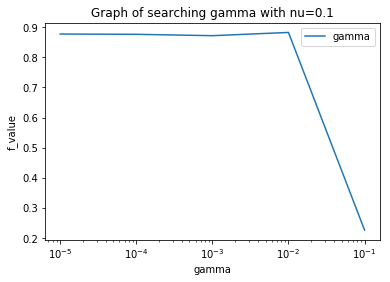

In [16]:
plt.plot(gamma_list, f_value_list, label = "gamma")
plt.legend()
plt.xlabel("gamma")
#対数軸にしたい場合
plt.xscale("log")
#軸の歯にを指定したい場合
#plt.xlim([0.053,0.057])
#plt.ylim([0.875,0.88])
plt.ylabel("f_value")
plt.title('Graph of searching gamma with nu=0.1')
plt.show

In [ ]:
#配列の頭から「１」を100個，「７」を20個取り出し予想
test = np.vstack((x_test_7[0:100], x_test_1[0:20]))
test1 = x_test_7[0:100]
pred = clf.predict(test)

clf = svm.OneClassSVM(nu = 0.2, kernel="rbf", gamma=0.001)
clf.fit(x_train_1)

In [98]:
#特徴抽出後
test_train = np.load("C:/Users/satok/.keras/datasets/fashion_mnist_pertype_feature_test/fashion_mnist_48_48_test_0.npy")
test_test = np.load("C:/Users/satok/.keras/datasets/fashion_mnist_pertype_feature_test/fashion_mnist_48_48_test_6.npy")

test_train = np.reshape(test_train, (len(test_train),512))
test_test = np.reshape(test_test, (len(test_test),512))

In [78]:
#特徴抽出前
img_array_list = []
test_list = resize_array_images(test_images,48,48,img_array_list)
test_train = test_list[np.where(test_labels == 0)[0]]
test_test = test_list[np.where(test_labels == 6)[0]]
#test_noise = test_list[np.where(test_labels == 2)[0]]

test_train = np.reshape(test_train, (len(test_train),2304))
test_test = np.reshape(test_test, (len(test_test),2304))
#test_noise = np.reshape(test, (len(noise),2304))

test_train = test_train.astype('float32') / 255.0
test_test = test_test.astype('float32') / 255.0
#test_noise = noise.astype('float32') / 255.0

In [70]:
#svm_train = np.vstack(svm_test_0[0:600],test[0:600])
#svm_test_0 = np.reshape(svm_test_0, (len(svm_test_0),512))
#svm_test_6 = np.reshape(svm_test_0, (len(svm_test_6),512))
#svm_test = np.vstack((svm_test_0[0:1000],svm_test_6[0:100]))
#svm_test.shape

(1100, 512)

In [99]:
#テストデータに加えるノイズの作成
train_noise = noise[0:divide]
train_noise.shape

(600, 512)

In [100]:
#学習用データの作成
tmp_train = []
tmp_train.extend(train)
tmp_train.extend(train_noise)
#評価用データの作成
tmp_test_train = []
tmp_test_train.extend(test_train)
tmp_test_train.extend(test_test)

In [101]:
svm_model = svm.OneClassSVM(nu = 0.1, kernel="rbf",gamma=0.0098)
#svm_model = svm.OneClassSVM(nu = 0.1, kernel="rbf",gamma=0.01)
svm_model.fit(tmp_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0098, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [103]:
#len(tmp_test_train)
test_train.shape

(1000, 512)

In [102]:
pred = svm_model.predict(tmp_test_train)
        
real_true_pred = pred[0:1000]
real_false_pred = pred[1000 : 2000]
        
tp = len(real_true_pred[real_true_pred == 1]) / len(real_true_pred)
fn = len(real_true_pred[real_true_pred == -1]) / len(real_true_pred)
        
fp = len(real_false_pred[real_false_pred == -1]) / len(real_false_pred)
tn = len(real_false_pred[real_false_pred == 1]) / len(real_false_pred)
        
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f_value = (2 * precision * recall) / (precision + recall)

print("f_value " + str(f_value))

f_value 0.8611764705882353


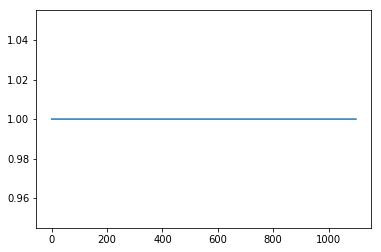

In [79]:
#予想された値をグラフ化し表示・保存
x = np.arange(0, 1100, 1)
plt.plot(x, pred)
#plt.savefig('SVMmnist.png')
plt.show()

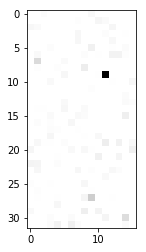

In [74]:
plt.imshow(svm_test_6[108].reshape(32,16),cmap='Greys')
plt.show()

In [8]:
#ファイル内のjpg画像を一括読み込みする関数
def fileRead():
    data = []
    for file in glob.glob("C:/Users/satok/.keras/datasets/fashion-mnist-images/*.jpg"):
        data.append( cv2.imread(file, 0) )
    return data

In [17]:
data = fileRead()

In [21]:
#len(data)
data[0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 7, 4, 0, 0, 8, 1, 2, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=uint8)

In [ ]:
hog_train = []
winsize = (48,48)
block_size = (16,16)
block_stride = (8,8)
cell_size = (8,8)
nbins = 9

hog = cv2.HOGDescriptor()
for filepath in data:
    hog_train.append(hog.compute(filepath))

hog_train = np.array(hog_train)